In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import sys; sys.path.append('../')
from pathlib import Path
from tqdm import tqdm
import json
import os
import numpy as np
from astropy.modeling.models import Ellipse2D
from astropy.coordinates import Angle
from regions import PixCoord, EllipsePixelRegion
import seaborn as sns;
import statistics
from statistics import mean, NormalDist
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['figure.dpi'] = 120

from matplotlib.patches import Ellipse
import matplotlib.image as mpimg

In [2]:
elipses_data = Path("..\cells_ellipses.csv")

In [3]:
df=pd.read_csv(elipses_data)
df

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,p1_0299_6.jpg,393922,{},34,0,"{""name"":""ellipse"",""cx"":472,""cy"":261,""rx"":12.51...","{""region_class"":""1""}"
1,p1_0299_6.jpg,393922,{},34,1,"{""name"":""ellipse"",""cx"":625,""cy"":376,""rx"":21.33...","{""region_class"":""1""}"
2,p1_0299_6.jpg,393922,{},34,2,"{""name"":""ellipse"",""cx"":635,""cy"":291,""rx"":15.33...","{""region_class"":""1""}"
3,p1_0299_6.jpg,393922,{},34,3,"{""name"":""ellipse"",""cx"":663,""cy"":205,""rx"":14,""r...","{""region_class"":""1""}"
4,p1_0299_6.jpg,393922,{},34,4,"{""name"":""ellipse"",""cx"":319,""cy"":307,""rx"":26,""r...","{""region_class"":""1""}"
...,...,...,...,...,...,...,...
3294,p23_0287_6.jpg,391717,{},0,0,{},{}
3295,p23_0287_7.jpg,326561,{},0,0,{},{}
3296,p23_0287_8.jpg,307907,{},0,0,{},{}
3297,p23_0287_11.jpg,374209,{},0,0,{},{}


In [4]:
df=df[df.region_count!=0]

In [5]:
ellipses = {
    'filename':[],
    'center_x':[],
    'center_y':[],
    'radius_x':[],
    'radius_y':[],
    'theta_rad':[],
    'label':[]
}
for row_id, df_x in df.iterrows():
    try:
        region_class = df_x.region_attributes
        labels=pd.json_normalize(json.loads(region_class))
        region_c = int(labels.region_class.values)
        ellipses['label'].append(region_c)
        #
        shapes=pd.json_normalize(json.loads(df_x.region_shape_attributes))
        ellipses['center_x'].append(shapes.cx.values[0])
        ellipses['center_y'].append(shapes.cy.values[0])
        ellipses['radius_x'].append(shapes.rx.values[0])
        ellipses['radius_y'].append(shapes.ry.values[0])
        ellipses['theta_rad'].append(shapes.theta.values[0])
        ellipses['filename'].append(df_x.filename)
        
    except Exception as e:
         print(df_x.filename,row_id,x.region_class.values,e)
ellipses_df= pd.DataFrame(ellipses)

<AxesSubplot:>

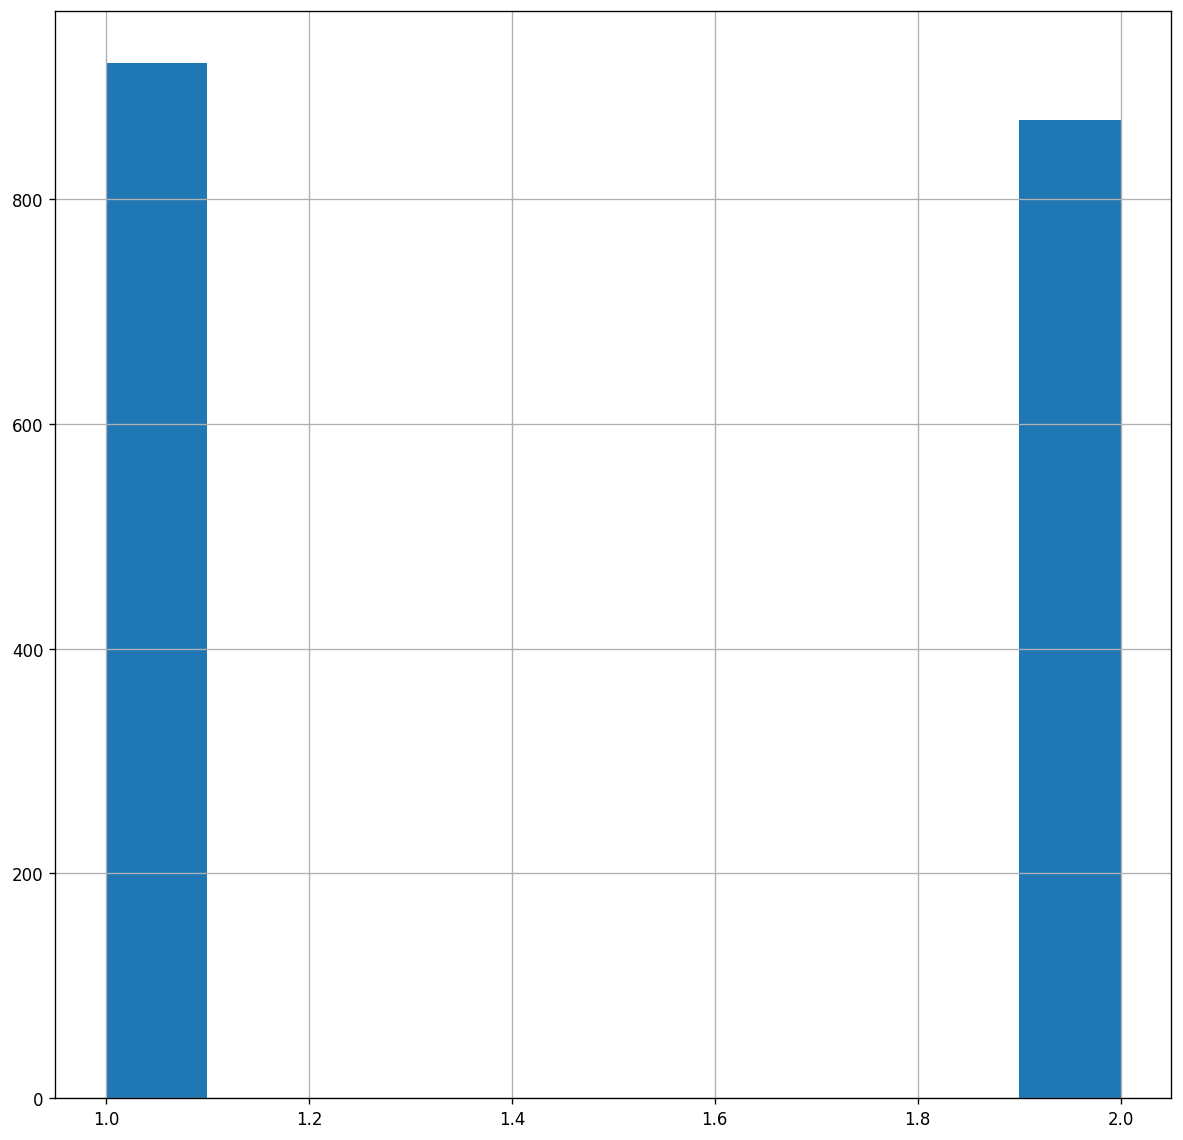

In [6]:
ellipses_df.label.hist()

<AxesSubplot:>

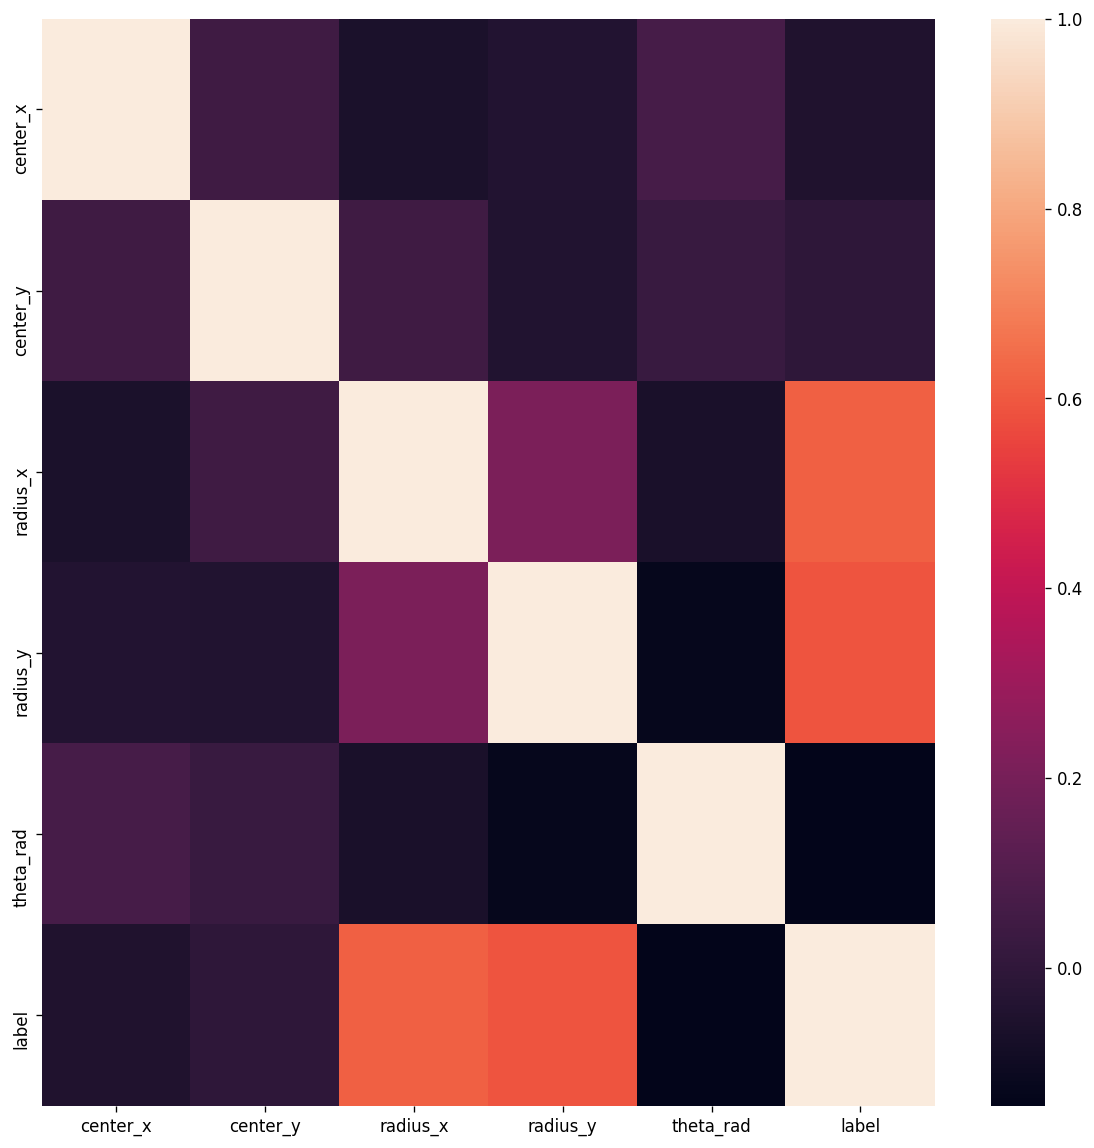

In [7]:
sns.heatmap(ellipses_df.corr())

In [8]:
data_path = Path("../data/Ki67/SHIDC-B-Ki-67/Train/")

In [9]:
colors = {'1':"blue",
         '2':'red'}

def rad_to_deg(rad):
    return rad*57.2957795


def show_ellipses(filename):
    filepath = os.path.join(data_path,filename)
    assert os.path.exists(filepath)
    print(filepath)
    img = mpimg.imread(filepath)
    ax = plt.gca()
    for ids, row in ellipses_df[ellipses_df.filename=="p1_0299_6.jpg"].iterrows():
        ax.add_patch(Ellipse((row.center_x,row.center_y),
                                width=row.radius_x*2,
                                height=row.radius_y*2,
                                angle=rad_to_deg(row.theta_rad), 
                                facecolor='none',
                                edgecolor=colors[str(row.label)]))
        
      
    plt.imshow(img)

In [ ]:
show_ellipses("p1_0299_6.jpg")

In [10]:
def check_ellipse(elipse_params,x,y):
    center_x=elipse_params.center_x
    center_y=elipse_params.center_y
    radius_x = elipse_params.radius_x
    radius_y = elipse_params.radius_y
    
    ellipse_eq = (((x-center_x)**2)/(radius_x**2))+(((y-center_y)**2)/(radius_y**2))
    if ellipse_eq <= 1:
        return True
    else:
        return False
    
def check_ellipse_rotated(elipse_params,x,y):
    
    center_x=elipse_params.center_x
    center_y=elipse_params.center_y
    radius_x = elipse_params.radius_x
    radius_y = elipse_params.radius_y
    
    angle=elipse_params.theta_rad

    ellipse_eq_1 = (((x-center_x)*cos(angle)+(y-center_y)*sin(angle))**2)/(radius_x)**2
    ellipse_eq_2 = (((x-center_x)*sin(angle)-(y-center_y)*cos(angle))**2)/(radius_y)**2
    if ellipse_eq_1+ellipse_eq_2 <= 1:
        return True
    else:
        return False

In [11]:
import PIL
from PIL import Image
import requests
from io import BytesIO
from PIL import ImageFilter
from PIL import ImageEnhance
from IPython.display import display
import numpy as np
from math import sin, cos
def get_ellipse(df,df_id,plot=False):
    elipse_params = df.iloc[df_id]
   # print(elipse_params)
    filepath = os.path.join(data_path,elipse_params.filename)
    assert os.path.exists(filepath)
    #print(filepath)
    pix_color_inside=[]
    
    
    with Image.open(filepath) as img:   
        #x_range = range(img.width)
        #y_range = range(img.height)
        radius_sum = int(elipse_params.radius_x+elipse_params.radius_y)
        start_x = elipse_params.center_x-radius_sum
        start_y = elipse_params.center_y-radius_sum
        if start_x < 0:
            start_x = 0
        if start_y < 0:
            start_y = 0
        end_x = elipse_params.center_x+radius_sum
        end_y = elipse_params.center_y+radius_sum
        if end_x > img.width:
            end_x = img.width
        if end_y > img.height:
            end_y = img.height
            
        x_range = range(start_x,end_x)
        y_range = range(start_y,end_y)
        for x in x_range:
            for y in y_range:
                if check_ellipse_rotated(elipse_params,x,y):
                    pix_color_inside.append(img.getpixel((x,y)))
                    if plot:
                        img.putpixel((x,y),(255, 0, 0, 255))
        if plot:
            img.putpixel((elipse_params.center_x,elipse_params.center_y),(0,255,0,255))
            
            img.putpixel((int(elipse_params.center_x+elipse_params.radius_x),
                          int( elipse_params.center_y+elipse_params.radius_y)),(0,255,0,255))
            
            
        if plot:
            img.show()
    return pix_color_inside

In [ ]:
import time

start = time.time()
x=get_ellipse(ellipses_df,1,plot=False)
end = time.time()
print(end - start)

In [ ]:
ellipses_df.size

In [ ]:
pixels_per_row=[]
for i in tqdm(range(len(ellipses_df.index))):
    row = ellipses_df.iloc[i]
    pixels=get_ellipse(ellipses_df,i,plot=False)
    pixels_per_row.append(pixels)
ellipses_df['pixels']=pixels_per_row

In [ ]:
ellipses_df

In [8]:
import pickle

In [ ]:

#with open('elipses_pixels.pickle', 'wb') as handle:
#    pickle.dump(ellipses_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
with open('elipses_pixels.pickle', 'rb') as handle:
    ellipses_df = pickle.load(handle)

In [10]:
ellipses_df

,filename,center_x,center_y,radius_x,radius_y,theta_rad,label,pixels
0,p1_0299_6.jpg,472,261,12.510,29.000,-0.040,1,"[(192, 177, 172), (193, 175, 171), (193, 175, ..."
1,p1_0299_6.jpg,625,376,21.333,34.493,-0.854,1,"[(214, 207, 191), (212, 206, 190), (208, 202, ..."
2,p1_0299_6.jpg,635,291,15.333,23.589,2.316,1,"[(194, 183, 187), (191, 182, 187), (186, 179, ..."
3,p1_0299_6.jpg,663,205,14.000,29.590,-0.393,1,"[(193, 188, 184), (196, 191, 185), (197, 193, ..."
4,p1_0299_6.jpg,319,307,26.000,28.474,-2.045,1,"[(222, 214, 175), (220, 212, 175), (218, 207, ..."
...,...,...,...,...,...,...,...,...
1786,p3_0248_1.jpg,344,75,35.355,21.000,-0.785,2,"[(157, 142, 119), (159, 144, 121), (153, 141, ..."
1787,p3_0248_1.jpg,705,1012,57.245,35.000,-0.338,2,"[(189, 187, 146), (185, 183, 142), (184, 182, ..."
1788,p3_0248_1.jpg,1005,1096,51.000,31.000,0.000,2,"[(140, 141, 146), (132, 125, 133), (132, 124, ..."
1789,p3_0248_6.jpg,296,163,41.000,41.000,0.000,2,"[(136, 123, 106), (126, 104, 106), (127, 105, ..."


In [11]:
for ids, row in ellipses_df[ellipses_df.label==1].iterrows():
    print(row)
    print(zip(*row.pixels))
    break

filename                                         p1_0299_6.jpg
center_x                                                   472
center_y                                                   261
radius_x                                                 12.51
radius_y                                                  29.0
theta_rad                                                -0.04
label                                                        1
pixels       [(192, 177, 172), (193, 175, 171), (193, 175, ...
Name: 0, dtype: object


In [12]:
color_dist_1 = {
    'red' : [],
    'green' : [],
    'blue' : []
}
color_dist_2 = {
    'red' : [],
    'green' : [],
    'blue' : []
}

for ids, row in ellipses_df[ellipses_df.label==1].iterrows():
    r,g,b = zip(*row.pixels)
    color_dist_1['red'].extend(r)
    color_dist_1['green'].extend(g)
    color_dist_1['blue'].extend(b)
    
for ids, row in ellipses_df[ellipses_df.label==2].iterrows():
    r,g,b = zip(*row.pixels)
    color_dist_2['red'].extend(r)
    color_dist_2['green'].extend(g)
    color_dist_2['blue'].extend(b)
    


In [13]:
color_df_1=pd.DataFrame(color_dist_1)

In [14]:
color_df_1

,red,green,blue
0,192,177,172
1,193,175,171
2,193,175,171
3,194,175,171
4,193,173,172
...,...,...,...
1037241,153,127,162
1037242,158,130,168
1037243,157,129,169
1037244,160,132,172


In [15]:
colors = ["#FF0B04", "#5AFF00","#4374B3"]
sns.set_palette(sns.color_palette(colors))

Text(0.5, 0.98, 'Ki67 - Komórki niebieskie')

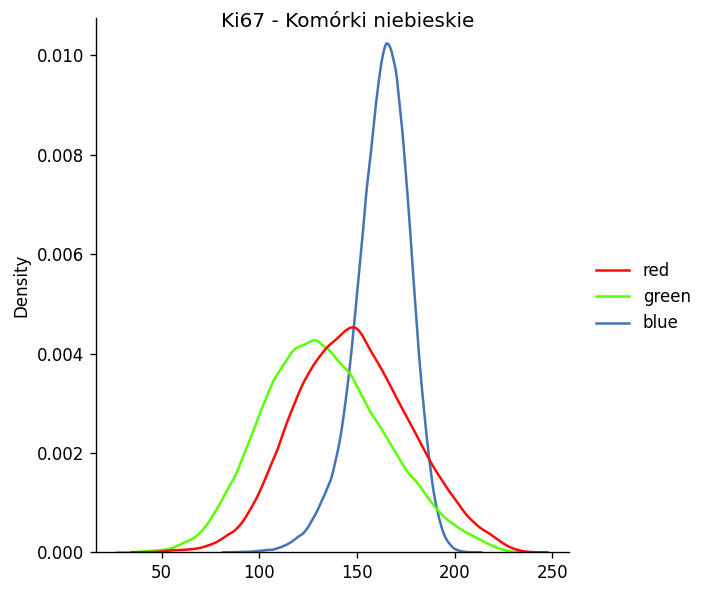

In [16]:
plot = sns.displot(color_df_1,kind="kde")
plot.fig.suptitle("Ki67 - Komórki niebieskie")

In [19]:
print(mean(color_df_1['blue']))
print(statistics.pstdev(color_df_1['blue']))

162.8042662974839
14.133422501229884


In [20]:
print(mean(color_df_1['red']))
print(statistics.pstdev(color_df_1['red']))

147.89261081749171
29.41359934013295


In [21]:
print(mean(color_df_1['green']))
print(statistics.pstdev(color_df_1['green']))

133.23393004166803
30.903213662200027


In [23]:
b1_min=min(color_df_1['blue'])
r1_min=min(color_df_1['red'])
g1_min=min(color_df_1['green'])

#b2_min=min(color_dist_2_mean['blue'])
#r2_min=min(color_dist_2_mean['red'])
#g2_min=min(color_dist_2_mean['green'])
b1_max=max(color_df_1['blue'])
r1_max=max(color_df_1['red'])
g1_max=max(color_df_1['green'])

#b2_max=max(color_dist_2_mean['blue'])
#r2_max=max(color_dist_2_mean['red'])
#g2_max=max(color_dist_2_mean['green'])

In [24]:
[b1_min,b1_max,r1_min,r1_max,g1_min,g1_max]

[84, 211, 40, 242, 33, 234]

In [ ]:
color_df_2=pd.DataFrame(color_dist_2)
plot = sns.displot(color_df_2,kind="kde")
plot.fig.suptitle("Ki67 - Komórki brąz")

In [ ]:
rx = ellipses_df.radius_x
ry = ellipses_df.radius_x

In [ ]:
colors = ["#FF0B04", "#5AFF00"]
sns.set_palette(sns.color_palette(colors))
plot = sns.displot(ellipses_df,hue='label',x="radius_x")
plot.fig.suptitle("Ki67 - Komórki promień x")

In [ ]:
colors = ["#FF0B04", "#5AFF00"]
sns.set_palette(sns.color_palette(colors))
plot = sns.displot(ellipses_df,hue='label',x="radius_y")
plot.fig.suptitle("Ki67 - Komórki promień y")

In [ ]:
print("blue cells")
print('x_radius mean: ',ellipses_df[ellipses_df.label==1].radius_x.mean())
print('x_radius median: ',ellipses_df[ellipses_df.label==1].radius_x.median())
print('y_radius mean: ',ellipses_df[ellipses_df.label==1].radius_y.mean())
print('y_radius median: ',ellipses_df[ellipses_df.label==1].radius_y.median())
print("brown cells")
print('x_radius mean: ',ellipses_df[ellipses_df.label==2].radius_x.mean())
print('x_radius median: ',ellipses_df[ellipses_df.label==2].radius_x.median())
print('y_radius mean: ',ellipses_df[ellipses_df.label==2].radius_y.mean())
print('y_radius median: ',ellipses_df[ellipses_df.label==2].radius_y.median())

In [ ]:
from statistics import mean
color_dist_1_mean = {
    'red' : [],
    'green' : [],
    'blue' : []
}
color_dist_2_mean = {
    'red' : [],
    'green' : [],
    'blue' : []
}

for ids, row in ellipses_df[ellipses_df.label==1].iterrows():
    r,g,b = zip(*row.pixels)
    r=mean(r)
    g=mean(g)
    b=mean(b)
    color_dist_1_mean['red'].append(r)
    color_dist_1_mean['green'].append(g)
    color_dist_1_mean['blue'].append(b)
    
for ids, row in ellipses_df[ellipses_df.label==2].iterrows():
    r,g,b = zip(*row.pixels)
    r=mean(r)
    g=mean(g)
    b=mean(b)
    color_dist_2_mean['red'].append(r)
    color_dist_2_mean['green'].append(g)
    color_dist_2_mean['blue'].append(b)
    

In [ ]:
color_df_1=pd.DataFrame(color_dist_1_mean)
colors = ["#FF0B04", "#5AFF00"]
sns.set_palette(sns.color_palette(colors))
plot = sns.displot(color_df_1,kind="kde")
plot.fig.suptitle("Ki67 - Komórki niebieskie")

In [ ]:
color_df_2=pd.DataFrame(color_dist_2_mean)
colors = ["#FF0B04", "#5AFF00"]
sns.set_palette(sns.color_palette(colors))
plot = sns.displot(color_df_2,kind="kde")
plot.fig.suptitle("Ki67 - Komórki brąz")

# Mean Ellipse as labled from vgg 

In [12]:
ellipses_mean = {
    'filename':[],
    'center_x':[],
    'center_y':[],
    'radius_x':[],
    'radius_y':[],
    'theta_rad':[],
    'label':[]
}

for row_id, df_x in df.iterrows():
    try:
        region_class = df_x.region_attributes
        labels=pd.json_normalize(json.loads(region_class))
        region_c = int(labels.region_class.values)
        ellipses_mean['label'].append(region_c)
        #
        shapes=pd.json_normalize(json.loads(df_x.region_shape_attributes))
        ellipses_mean['center_x'].append(shapes.cx.values[0])
        ellipses_mean['center_y'].append(shapes.cy.values[0])
        ellipses_mean['radius_x'].append(shapes.rx.values[0])
        ellipses_mean['radius_y'].append(shapes.ry.values[0])
        ellipses_mean['theta_rad'].append(shapes.theta.values[0])
        ellipses_mean['filename'].append(df_x.filename)
        
    except Exception as e:
         print(df_x.filename,row_id,x.region_class.values,e)
ellipses_df_mean= pd.DataFrame(ellipses_mean)

In [13]:
ellipses_df

,filename,center_x,center_y,radius_x,radius_y,theta_rad,label
0,p1_0299_6.jpg,472,261,12.510,29.000,-0.040,1
1,p1_0299_6.jpg,625,376,21.333,34.493,-0.854,1
2,p1_0299_6.jpg,635,291,15.333,23.589,2.316,1
3,p1_0299_6.jpg,663,205,14.000,29.590,-0.393,1
4,p1_0299_6.jpg,319,307,26.000,28.474,-2.045,1
...,...,...,...,...,...,...,...
1786,p3_0248_1.jpg,344,75,35.355,21.000,-0.785,2
1787,p3_0248_1.jpg,705,1012,57.245,35.000,-0.338,2
1788,p3_0248_1.jpg,1005,1096,51.000,31.000,0.000,2
1789,p3_0248_6.jpg,296,163,41.000,41.000,0.000,2


In [14]:
ellipses_df_mean.loc[ellipses_df_mean.label==1,'radius_x']=18
ellipses_df_mean.loc[ellipses_df_mean.label==1,'radius_y']=20

ellipses_df_mean.loc[ellipses_df_mean.label==2,'radius_x']=33
ellipses_df_mean.loc[ellipses_df_mean.label==2,'radius_y']=35

In [15]:
ellipses_df_mean

,filename,center_x,center_y,radius_x,radius_y,theta_rad,label
0,p1_0299_6.jpg,472,261,18.0,20.0,-0.040,1
1,p1_0299_6.jpg,625,376,18.0,20.0,-0.854,1
2,p1_0299_6.jpg,635,291,18.0,20.0,2.316,1
3,p1_0299_6.jpg,663,205,18.0,20.0,-0.393,1
4,p1_0299_6.jpg,319,307,18.0,20.0,-2.045,1
...,...,...,...,...,...,...,...
1786,p3_0248_1.jpg,344,75,33.0,35.0,-0.785,2
1787,p3_0248_1.jpg,705,1012,33.0,35.0,-0.338,2
1788,p3_0248_1.jpg,1005,1096,33.0,35.0,0.000,2
1789,p3_0248_6.jpg,296,163,33.0,35.0,0.000,2


In [16]:
x=get_ellipse(ellipses_df_mean,1,plot=True)
x=get_ellipse(ellipses_df,1,plot=True)

In [17]:
pixels_per_row=[]
for i in tqdm(range(len(ellipses_df_mean.index))):
    row = ellipses_df_mean.iloc[i]
    pixels=get_ellipse(ellipses_df_mean,i,plot=False)
    pixels_per_row.append(pixels)
ellipses_df_mean['pixels']=pixels_per_row

100%|██████████████████████████████████████████████████████████████████████████████| 1791/1791 [14:16<00:00,  2.09it/s]


In [ ]:
ellipses_df_mean

In [ ]:
color_dist_1_mean = {
    'red' : [],
    'green' : [],
    'blue' : [],
    'grayscale' : []
}
color_dist_2_mean = {
    'red' : [],
    'green' : [],
    'blue' : [],
    'grayscale' : []
}

for ids, row in ellipses_df_mean[ellipses_df_mean.label==1].iterrows():
    r,g,b = zip(*row.pixels)
    r=mean(r)
    g=mean(g)
    b=mean(b)
    color_dist_1_mean['red'].append(r)
    color_dist_1_mean['green'].append(g)
    color_dist_1_mean['blue'].append(b)
    grey= 0.2989 * r + 0.5870 * g + 0.1140 * b
    color_dist_1_mean['grayscale'].append(grey)
    
for ids, row in ellipses_df_mean[ellipses_df_mean.label==2].iterrows():
    r,g,b = zip(*row.pixels)
    r=mean(r)
    g=mean(g)
    b=mean(b)
    color_dist_2_mean['red'].append(r)
    color_dist_2_mean['green'].append(g)
    color_dist_2_mean['blue'].append(b)
    grey= 0.2989 * r + 0.5870 * g + 0.1140 * b
    color_dist_2_mean['grayscale'].append(grey)

In [ ]:
color_df_1=pd.DataFrame(color_dist_1_mean)
colors = ["#FF0B04", "#5AFF00"]
sns.set_palette(sns.color_palette(colors))
plot = sns.displot(color_df_1,kind="kde")
plot.fig.suptitle("Ki67 - Komórki niebieskie")

In [ ]:
color_df_2=pd.DataFrame(color_dist_2_mean)
colors = ["#FF0B04", "#5AFF00"]
sns.set_palette(sns.color_palette(colors))
plot = sns.displot(color_df_2,kind="kde")
plot.fig.suptitle("Ki67 - Komórki brąz")

In [ ]:
b1_min=min(color_dist_1_mean['blue'])
r1_min=min(color_dist_1_mean['red'])
g1_min=min(color_dist_1_mean['green'])

b2_min=min(color_dist_2_mean['blue'])
r2_min=min(color_dist_2_mean['red'])
g2_min=min(color_dist_2_mean['green'])

In [ ]:
b1_max=max(color_dist_1_mean['blue'])
r1_max=max(color_dist_1_mean['red'])
g1_max=max(color_dist_1_mean['green'])

b2_max=max(color_dist_2_mean['blue'])
r2_max=max(color_dist_2_mean['red'])
g2_max=max(color_dist_2_mean['green'])

# Distributions

In [ ]:
sigma=statistics.pstdev(color_dist_1_mean['red'])
mu=statistics.mean(color_dist_1_mean['red'])
red_dist = NormalDist(mu,sigma)

sigma=statistics.pstdev(color_dist_1_mean['blue'])
mu=statistics.mean(color_dist_1_mean['blue'])
blue_dist = NormalDist(mu,sigma)

sigma=statistics.pstdev(color_dist_1_mean['green'])
mu=statistics.mean(color_dist_1_mean['green'])
green_dist = NormalDist(mu,sigma)

In [ ]:
blue_cells_dist = {
    'blue':blue_dist,
    'red':red_dist,
    'green':green_dist,
}

In [ ]:
for key in blue_cells_dist.keys():
    print(blue_cells_dist[key])

In [ ]:
sigma=statistics.pstdev(color_dist_2_mean['red'])
mu=statistics.mean(color_dist_2_mean['red'])
red_dist = NormalDist(mu,sigma)

sigma=statistics.pstdev(color_dist_2_mean['blue'])
mu=statistics.mean(color_dist_2_mean['blue'])
blue_dist = NormalDist(mu,sigma)

sigma=statistics.pstdev(color_dist_2_mean['green'])
mu=statistics.mean(color_dist_2_mean['green'])
green_dist = NormalDist(mu,sigma)

In [ ]:
brown_cells_dist = {
    'blue':blue_dist,
    'red':red_dist,
    'green':green_dist,
}

In [ ]:
for key in brown_cells_dist.keys():
    print(brown_cells_dist[key])

In [ ]:
plot_list_red_1 = []
plot_list_blue_1 = []
plot_list_green_1 = []

plot_list_red_2 = []
plot_list_blue_2 = []
plot_list_green_2 = []

for i in range(255):
    plot_list_red_1.append(blue_cells_dist['red'].pdf(i))
    plot_list_green_1.append(blue_cells_dist['green'].pdf(i))
    plot_list_blue_1.append(blue_cells_dist['blue'].pdf(i))

    plot_list_red_2.append(brown_cells_dist['red'].pdf(i))
    plot_list_blue_2.append(brown_cells_dist['green'].pdf(i))
    plot_list_green_2.append(brown_cells_dist['blue'].pdf(i))
    

In [ ]:
plt.plot(plot_list_red_1,color='red')

plt.plot(plot_list_blue_1,color='blue')

plt.plot(plot_list_green_1,color='green')



plt.plot(plot_list_red_2,color='#b30000')


plt.plot(plot_list_blue_2,color='#00b3b3')

plt.plot(plot_list_green_2,color="#00b300")

plt.axvline(r1_min, 0, 1,color='red')
plt.axvline(r1_max, 0, 1,color='red')
plt.axvline(b1_min, 0, 1,color='blue')
plt.axvline(b1_max, 0, 1,color='blue')
plt.axvline(g1_min, 0, 1,color='green')
plt.axvline(g1_max, 0, 1,color='green')
plt.axvline(r2_min, 0, 1,color='#b30000')
plt.axvline(r2_max, 0, 1,color='#b30000')
plt.axvline(g2_min, 0, 1,color='#00b300')
plt.axvline(g2_max, 0, 1,color='#00b300')
plt.axvline(b2_min, 0, 1,color='#00b3b3')
plt.axvline(b2_max, 0, 1,color='#00b3b3')
plt.show()

In [ ]:
[b1_min,b1_max,r1_min,r1_max,g1_min,g1_min]

In [ ]:
[b2_min,b2_max,r2_min,r2_max,g2_min,g2_min]

# Greyscale

In [ ]:
mean(color_dist_1_mean['grayscale'])

In [ ]:
sigma=statistics.pstdev(color_dist_1_mean['grayscale'])
mu=statistics.mean(color_dist_1_mean['grayscale'])
grey_dist_1= NormalDist(mu,sigma)
grey_dist_1

In [ ]:
sigma=statistics.pstdev(color_dist_2_mean['grayscale'])
mu=statistics.mean(color_dist_2_mean['grayscale'])
grey_dist_2= NormalDist(mu,sigma)
grey_dist_2

In [ ]:
gray_min_1 = min(color_dist_1_mean['grayscale']) 
gray_max_1 = max(color_dist_1_mean['grayscale']) 

gray_min_2 = min(color_dist_2_mean['grayscale']) 
gray_max_2 = max(color_dist_2_mean['grayscale']) 

In [ ]:
plot_list_gray_1 = []
plot_list_gray_2 = []
for i in range(255):
    plot_list_gray_1.append(grey_dist_1.pdf(i))
    
    plot_list_gray_2.append(grey_dist_2.pdf(i))

In [ ]:
plt.plot(plot_list_gray_2,color='red')

plt.plot(plot_list_gray_1,color='blue')

plt.axvline(gray_min_2, 0, 1,color='red')
plt.axvline(gray_max_2, 0, 1,color='red')
plt.axvline(gray_min_1, 0, 1,color='blue')
plt.axvline(gray_max_1, 0, 1,color='blue')
print(grey_dist_1.pdf(gray_min_1),grey_dist_1.pdf(gray_max_1))
print(grey_dist_2.pdf(gray_min_2),grey_dist_2.pdf(gray_max_2))

print(grey_dist_1.pdf(0),grey_dist_1.pdf(255))
print(grey_dist_2.pdf(0),grey_dist_2.pdf(255))
plt.show()

# Elipses check from experiment

In [78]:
results_file = "../src/results_elipses/results_p3_0286_1.pickle"
assert os.path.exists(results_file)

In [79]:
with open(results_file, 'rb') as handle:
    res_elipses = pickle.load(handle)

In [80]:
res_elipses

,center_x,center_y,theta,colors,radius_x,radius_y,label,img_name,pdf
0,399,203,78.539816,"[(147, 155, 176), (145, 155, 182), (145, 155, ...",18,20,1,p3_0286_1,0.023675
1,414,203,78.539816,"[(133, 142, 181), (121, 128, 172), (123, 132, ...",18,20,1,p3_0286_1,0.025098
2,309,220,78.539816,"[(202, 221, 201), (200, 219, 199), (199, 218, ...",18,20,1,p3_0286_1,0.023818
3,324,223,78.539816,"[(71, 71, 157), (93, 82, 161), (87, 75, 161), ...",18,20,1,p3_0286_1,0.023841
4,1173,263,31.415927,"[(143, 150, 179), (141, 141, 177), (143, 143, ...",18,20,1,p3_0286_1,0.018860
...,...,...,...,...,...,...,...,...,...
127,432,1083,78.539816,"[(209, 206, 173), (208, 222, 186), (210, 222, ...",18,20,1,p3_0286_1,0.024998
128,453,1103,31.415927,"[(118, 73, 96), (126, 84, 106), (121, 78, 105)...",18,20,1,p3_0286_1,0.023714
129,147,1163,31.415927,"[(168, 163, 170), (162, 162, 172), (164, 162, ...",18,20,1,p3_0286_1,0.028226
130,165,1160,31.415927,"[(167, 166, 172), (166, 170, 173), (167, 168, ...",18,20,1,p3_0286_1,0.028216


In [75]:
elipses_colors = {'1':"blue",
         '2':'red'}

def show_ellipses(res,filename):
    filepath = os.path.join(data_path,filename+".jpg")
    assert os.path.exists(filepath)
    print(filepath)
    img = mpimg.imread(filepath)
    ax = plt.gca()
    for ids, row in res[res.img_name==filename].iterrows():
        label = str(row.label)
        ax.add_patch(Ellipse((row.center_x,row.center_y),
                                width=row.radius_x*2,
                                height=row.radius_y*2,
                                angle=rad_to_deg(row.theta), 
                                facecolor='none',
                                edgecolor=elipses_colors[label]))
        
    plt.imshow(img)

..\data\Ki67\SHIDC-B-Ki-67\Train\p3_0286_1.jpg


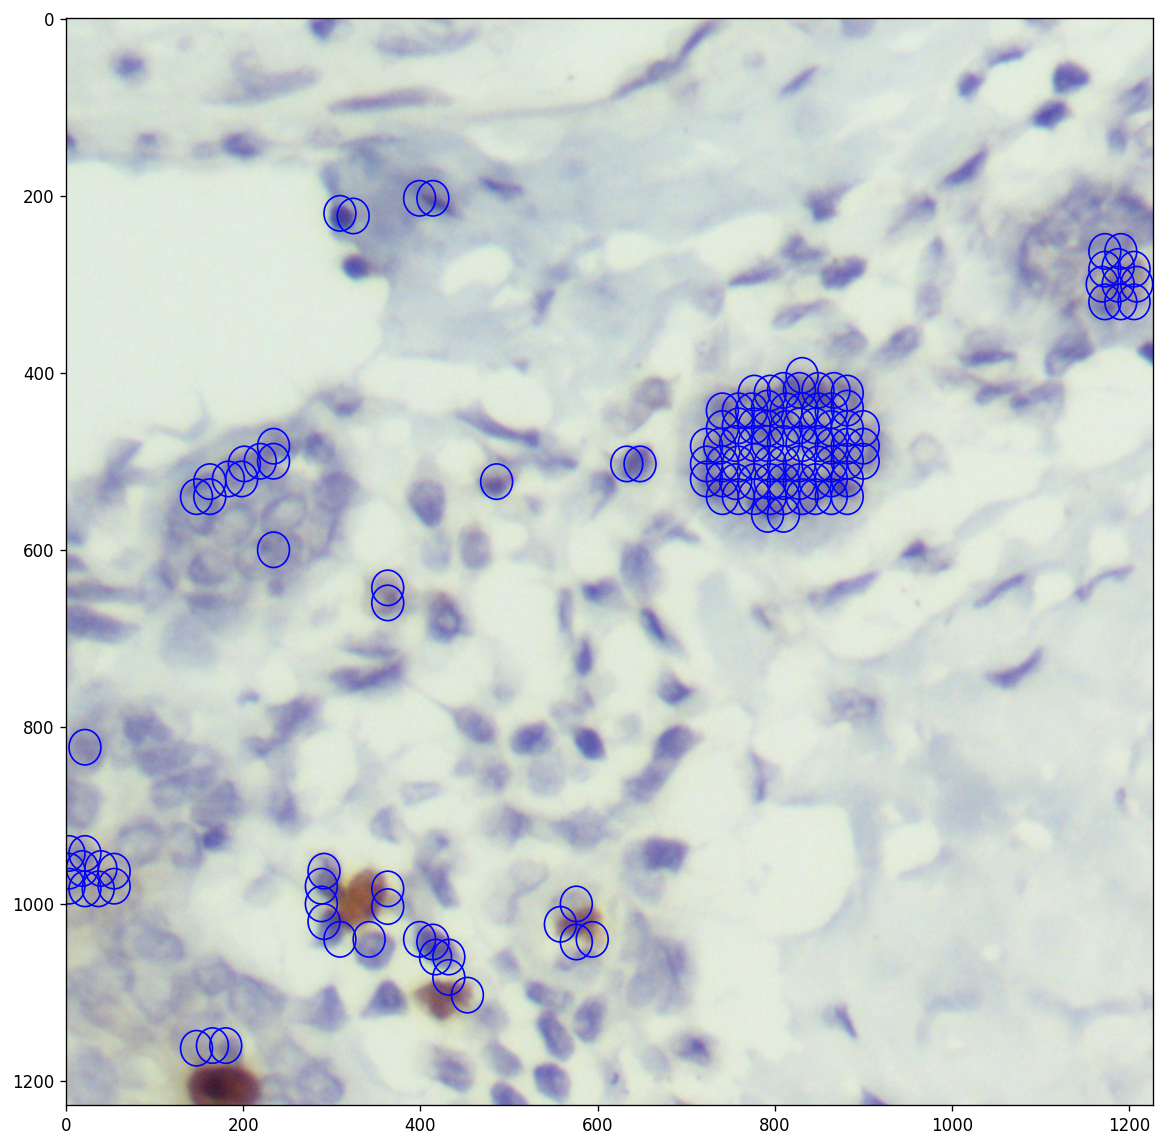

In [81]:
show_ellipses(res_elipses,'p3_0286_1')

In [38]:
NormalDist(mu=162.8042662974839, sigma=14.133422501229884)

NormalDist(mu=162.8042662974839, sigma=14.133422501229884)

In [42]:
x=NormalDist(mu=162.8042662974839, sigma=14.133422501229884)

In [47]:
x._mu
x._sigma

14.133422501229884

In [50]:
x.pdf(x._mu+x._sigma)

0.017120462117232192

In [49]:
x.pdf(x._mu)

0.028226870056896475